In [2]:
# Define variables.
DATA_FILE_TYPES = ['info', 'cat', 'dat']
DATA_FOLDER = "./decrompressed/"
DATA_PREFIXES = {
    'train': 'smallnorb-5x46789x9x18x6x2x96x96-training-',
    'test': 'smallnorb-5x01235x9x18x6x2x96x96-testing-',
}

PREP_BATCH_SIZE = 8
PREP_CAMERA = 0
PREP_IMAGE_SIZE = 96
PREP_SHUFFLE_TRAIN = True
PREP_SHUFFLE_TEST = False

RUN_DEVICE = 'cuda'
RUN_DISPLAY_STEP = 500
RUN_EPOCHS = 5
RUN_NOISE_SIZE = 100
RUN_Z_DIM = 100
RUN_CRITIC_REPEAT = 5
RUN_CRITIC_LAMBDA = 10

OPT_BETA_1 = 0.5 
OPT_BETA_2 = 0.999
OPT_LR = 0.0002

In [3]:
# Install additional packages.
!pip install -qq imageio

# Import packages.
import os
import random
import struct
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch as to
import torchvision as tov
from tqdm.auto import tqdm

In [4]:
# Helper function for reading int from file.
def read_int(f):
    num, = struct.unpack('i', f.read(4))
    return num

# From https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/ 
# "The magic number encodes the element type of the matrix"
# Note: I only copied over the ones I needed for these files.
map_magic_number_to_data_type = {
    '1e3d4c55': np.uint8,
    '1e3d4c54': np.int32,
}

loaded_data = {}

for dataset, prefix in DATA_PREFIXES.items():
    for filetype in DATA_FILE_TYPES:
        filename = prefix + filetype + ".mat"
        print('Reading {}'.format(filename))
        
        file_loc = os.path.join(DATA_FOLDER, filename)
        with open( file_loc, 'rb') as f:
            # Read the magic_num, convert it to hexadecimal and look up the data_type.
            raw_magic_num = read_int(f)
            magic_num = format(raw_magic_num, '02x')
            data_type = map_magic_number_to_data_type[magic_num]
            print('dtype', data_type)

            # Read how many dimensions to expect.
            ndim = read_int(f)
            
            # Read at least 3 ints, or however many ndim there are.
            shape = [
                read_int(f)
                for i in range(max(ndim, 3))
            ]   
            
            # But in case ndims < 3, take at most n_dim elements.
            shape = shape[:ndim]
            print('shape', shape)
    
            # Now load the actual data.
            loaded_data[(dataset, filetype)] = np.fromfile(
                f, 
                dtype=data_type, 
                count=np.prod(shape)
            ).reshape(shape)

Reading smallnorb-5x46789x9x18x6x2x96x96-training-info.mat
dtype <class 'numpy.int32'>
shape [24300, 4]
Reading smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat
dtype <class 'numpy.int32'>
shape [24300]
Reading smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat
dtype <class 'numpy.uint8'>
shape [24300, 2, 96, 96]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-info.mat
dtype <class 'numpy.int32'>
shape [24300, 4]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-cat.mat
dtype <class 'numpy.int32'>
shape [24300]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-dat.mat
dtype <class 'numpy.uint8'>
shape [24300, 2, 96, 96]


In [5]:
# Function for showing the images.
def show_tensor_images(image):
    plt.subplot(1, 2, 1)

    # Show the first channel of the data.
    plt.imshow(image[0], cmap="gray")   

    # Add a third channel for showing the image as RGB.
    #image3 = np. moveaxis ( np.concatenate( (image, image[0:1]) ), 0, -1 ) 
    #plt.subplot(1, 2, 2)

    # Show the RGB version of the image.
    #plt.imshow( image3, cmap="gray_r")
    plt.show()

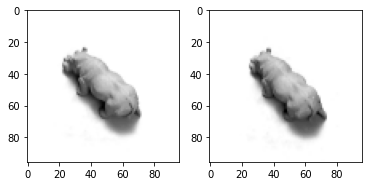

0 [ 4  5 14  1]


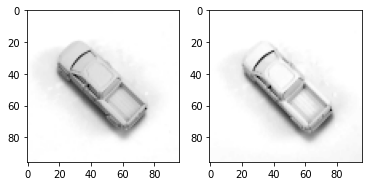

3 [ 8  8 16  5]


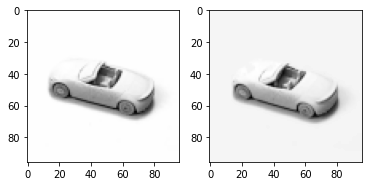

4 [ 8  0 22  3]


In [6]:
# Show some random original images.
idx = np.random.randint( loaded_data[('train', 'cat')].shape[0], size=3)

for i in idx:
    image  = loaded_data[('train', 'dat')][i]
    plt.subplot(1, 2, 1)
    # Show the first channel of the data.
    plt.imshow(image[0], cmap="gray")   
    
    # Add a third channel for showing the image as RGB.
    #image3 = np. moveaxis ( np.concatenate( (image, image[0:1]) ), 0, -1 ) 
    plt.subplot(1, 2, 2)
    
    # Show the RGB version of the image.
    #plt.imshow( image3, cmap="gray_r")
    plt.imshow(image[1], cmap="gray") 
    plt.show()
    
    # Print metadata: category and properties.
    print( loaded_data[('train', 'cat')][i], loaded_data[('train', 'info')][i]  )

20


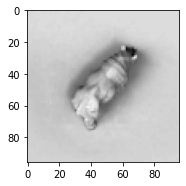

30


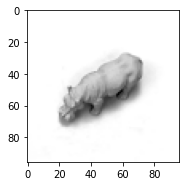

80


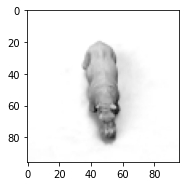

90


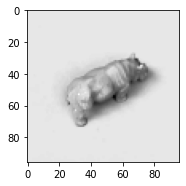

100


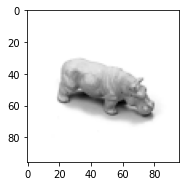

125


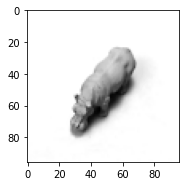

135


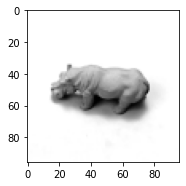

145


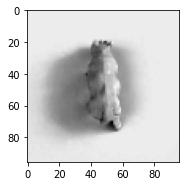

160


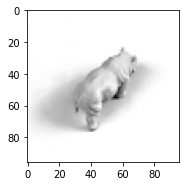

165


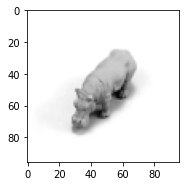

180


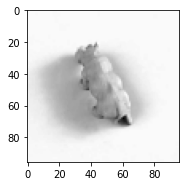

190


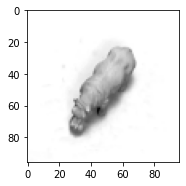

210


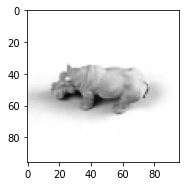

215


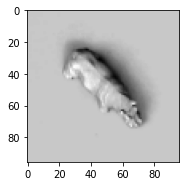

250


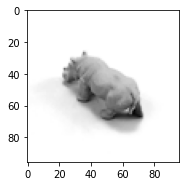

265


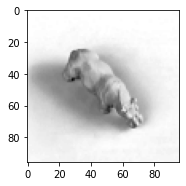

320


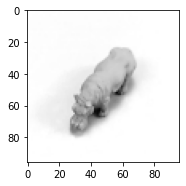

340


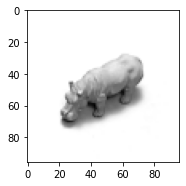

370


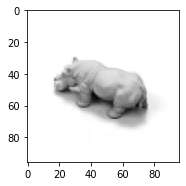

390


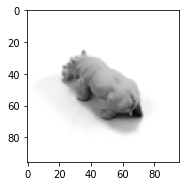

405


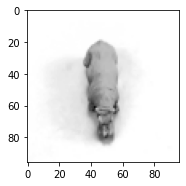

420


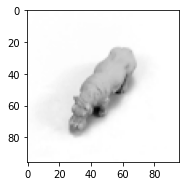

430


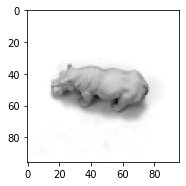

455


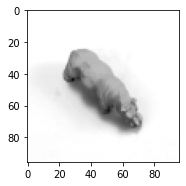

475


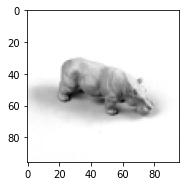

500


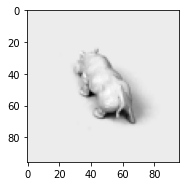

520


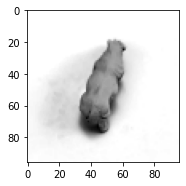

545


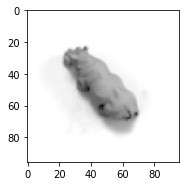

550


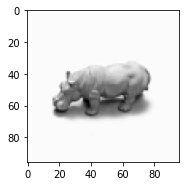

575


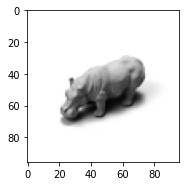

In [7]:
# Show all images for one toy.
infos = loaded_data[('train', 'info')]
cats = loaded_data[('train', 'cat')]

selection = []        
for i in range(0, len(infos)):
    if infos[i][0] == 4 and cats[i] == 0:
        selection.append(i)
selection = np.array(selection)

for i in range(0, 30):
    idx = selection[i]
    print(idx)
    image  = loaded_data[('train', 'dat')][idx]
    show_tensor_images(image)

In [8]:
# Preprocess images.
# Load the content from the dat files.
images_train = to.from_numpy(loaded_data[('train', 'dat')])
images_test  = to.from_numpy(loaded_data[('test', 'dat')])

# Load the content from the cat files.
category_train = to.from_numpy(loaded_data[('train', 'cat')])
category_test  = to.from_numpy(loaded_data[('test', 'cat')])

# Define transformation for the data.
transform = tov.transforms.Compose([
    tov.transforms.Lambda(lambda x: x[PREP_CAMERA]),
    tov.transforms.Lambda(lambda x: (x - 127.5) / 127.5),
    tov.transforms.ToPILImage(),
    tov.transforms.Resize(PREP_IMAGE_SIZE),
    tov.transforms.ToTensor()
])

# Transform the training data.
data_train = to.empty([images_train.size(0), 1, PREP_IMAGE_SIZE, PREP_IMAGE_SIZE])
for i in range(0, images_train.size(0)):
    data_train[i] = transform(images_train[i])

# Transform the test data.
data_test = to.empty([images_test.size(0), 1, PREP_IMAGE_SIZE, PREP_IMAGE_SIZE])
for i in range(0, images_test.size(0)):
    data_test[i] = transform(images_test[i])
    
# Create a dataloader for the traning data.
data_train = to.utils.data.TensorDataset(data_train, category_train)
loader_train = to.utils.data.DataLoader(data_train, batch_size=PREP_BATCH_SIZE, shuffle=PREP_SHUFFLE_TRAIN)

# Create a dataloader for the test data.
data_test = to.utils.data.TensorDataset(data_test, category_train)
loader_test = to.utils.data.DataLoader(data_test, batch_size=PREP_BATCH_SIZE, shuffle=PREP_SHUFFLE_TEST)

In [9]:
class Generator(to.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Build the neural network
        #self.gen1 = to.nn.Sequential(
        #    to.nn.Linear(100, 24*24*256)
        #)
        #self.temp = to.nn.Sequential(
        #    self.normalization_and_activation(24*24*256)
        #)
        self.gen2 = to.nn.Sequential(
            to.nn.ConvTranspose2d(100, 256, kernel_size=(5, 5), stride=(1, 1), bias=False),
            self.normalization_and_activation(256),
            to.nn.ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), bias=False),
            self.normalization_and_activation(128),
            to.nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), bias=False),
            self.normalization_and_activation(64),
            to.nn.ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), bias=False) ,
            to.nn.Tanh()
        )

    def normalization_and_activation(self, output_channels):
        # DGAN generator block.
        return to.nn.Sequential(
            to.nn.BatchNorm2d(output_channels),
            to.nn.ReLU()
        )

    def forward(self, noise):
        # Unspueeze the noise vector and send it into the generator.
        #x = self.gen1(noise)
        #print(x.size())
        x = noise.view(len(noise), 100, 1, 1)
        #x = self.temp(x)
        #x = x.view((24, 24, 256))
        return self.gen2(x)

def get_noise(n_samples, z_dim, device='cpu'):
    # Create a noise vector with dimensions (n_samples, z_dim).
    return to.randn(n_samples, z_dim, device=device)

In [10]:
class Discriminator(to.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Discriminator net.
        self.disc = to.nn.Sequential(
            to.nn.Conv2d(1, 64, (5, 5), stride=(2, 2)),
            to.nn.LeakyReLU(0.2),
            to.nn.Dropout(0.4),
            to.nn.Conv2d(64, 128, (5, 5), stride=(2, 2)),
            to.nn.LeakyReLU(0.2),
            to.nn.Dropout(0.4),
            to.nn.Conv2d(128, 256, (5, 5), stride=(2, 2)),
            #to.nn.Flatten(),
            #to.nn.Linear(128, 1)
        )

    def forward(self, image):
        # Create a 1-dimension tensor representing fake/real, based on the given image.
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [11]:
# Define the loss function.
criterion = to.nn.BCEWithLogitsLoss()

# Initialize the generator and discriminator.
gen = Generator().to(RUN_DEVICE)
disc = Discriminator().to(RUN_DEVICE)

# Define the optimizer for generator and discriminator.
gen_opt = to.optim.Adam(gen.parameters(), lr=OPT_LR, betas=(OPT_BETA_1, OPT_BETA_2))
disc_opt = to.optim.Adam(disc.parameters(), lr=OPT_LR, betas=(OPT_BETA_1, OPT_BETA_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
#def weights_init(m):
#    if isinstance(m, to.nn.Conv2d) or isinstance(m, to.nn.ConvTranspose2d):
#        to.nn.init.normal_(m.weight, 0.0, 0.02)
#    if isinstance(m, to.nn.BatchNorm2d):
#        to.nn.init.normal_(m.weight, 0.0, 0.02)
#        to.nn.init.constant_(m.bias, 0)
#gen = gen.apply(weights_init)
#disc = disc.apply(weights_init)

  0%|          | 0/3038 [00:00<?, ?it/s]

torch.Size([8, 1, 45, 45])
8


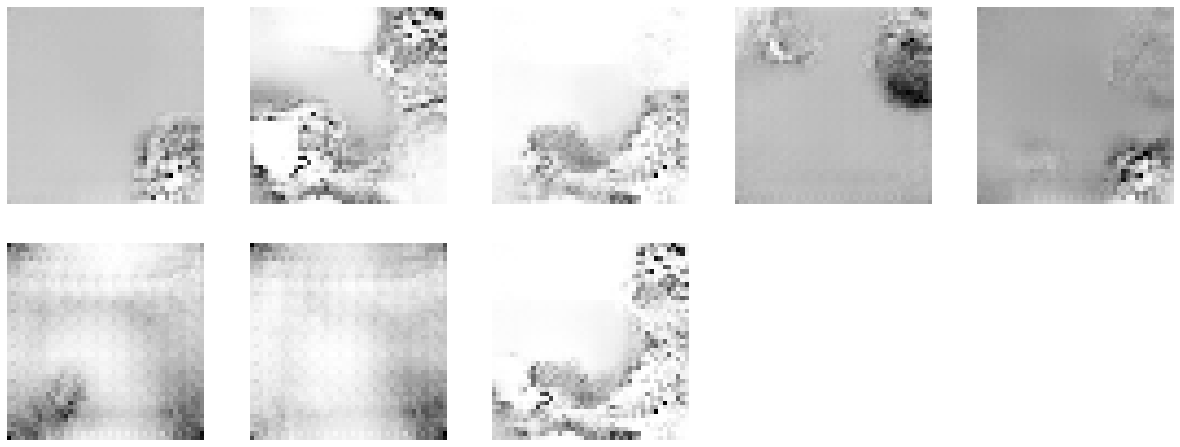

Epoch 0, Generator loss: 0.8858307600021362, discriminator loss: 0.5735971927642822


  0%|          | 0/3038 [00:00<?, ?it/s]

torch.Size([8, 1, 45, 45])
8


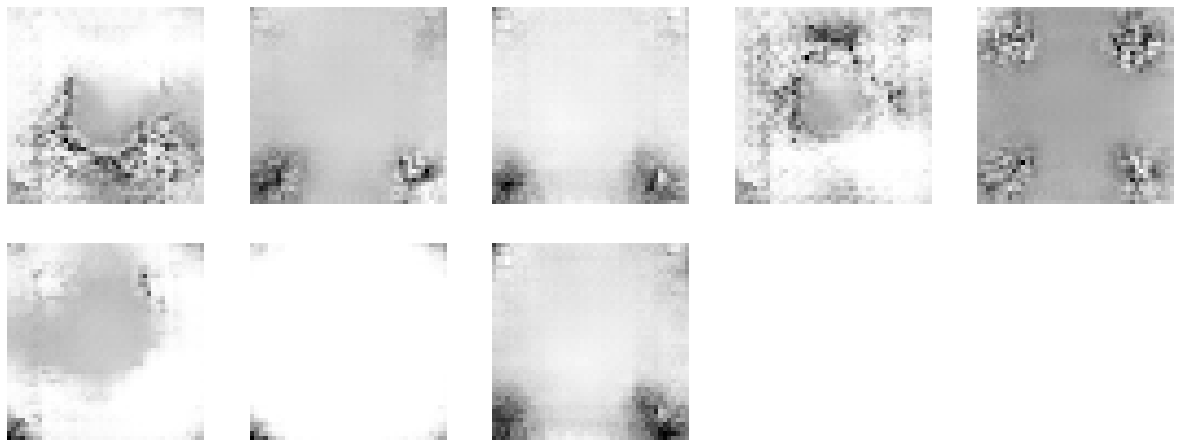

Epoch 1, Generator loss: 1.095255970954895, discriminator loss: 0.45604369044303894


  0%|          | 0/3038 [00:00<?, ?it/s]

torch.Size([8, 1, 45, 45])
8


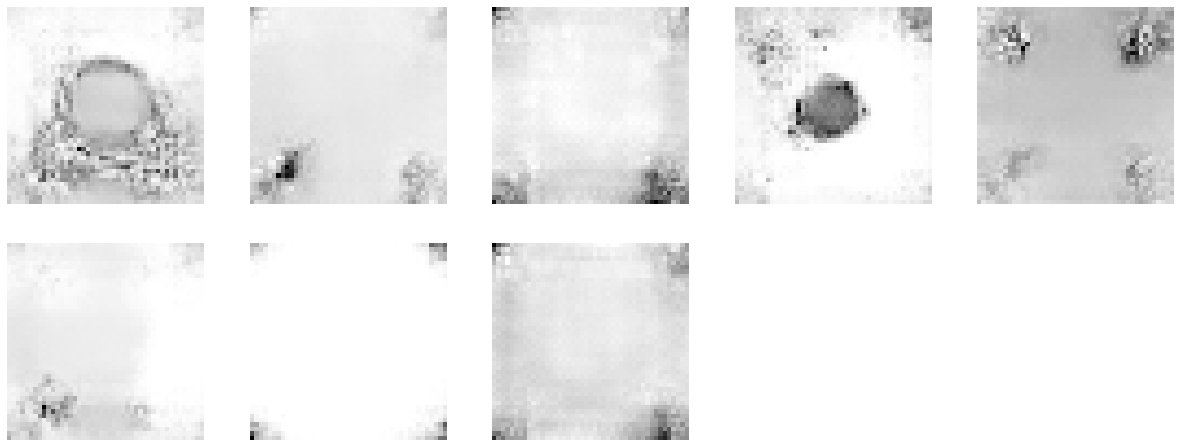

Epoch 2, Generator loss: 1.3357431888580322, discriminator loss: 0.3935088515281677


  0%|          | 0/3038 [00:00<?, ?it/s]

torch.Size([8, 1, 45, 45])
8


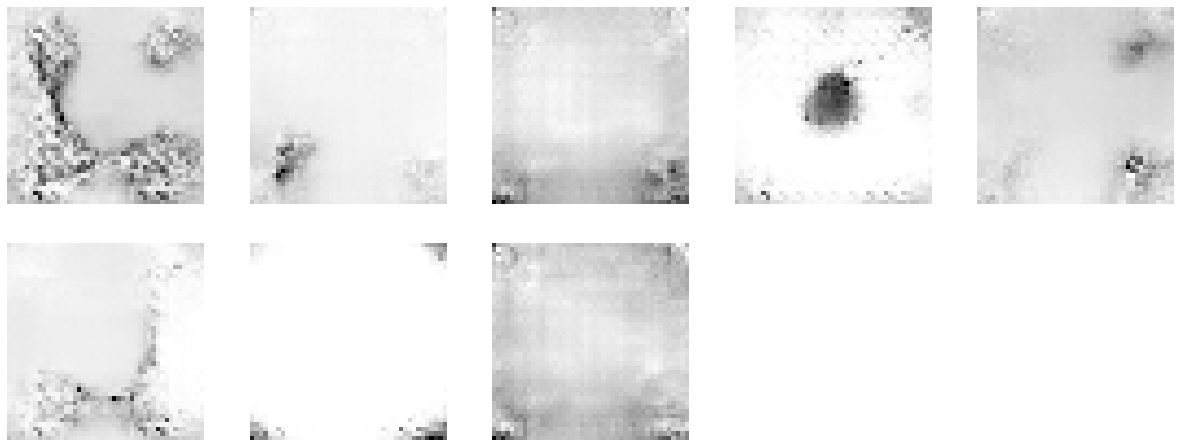

Epoch 3, Generator loss: 1.9934440851211548, discriminator loss: 0.4789506793022156


  0%|          | 0/3038 [00:00<?, ?it/s]

torch.Size([8, 1, 45, 45])
8


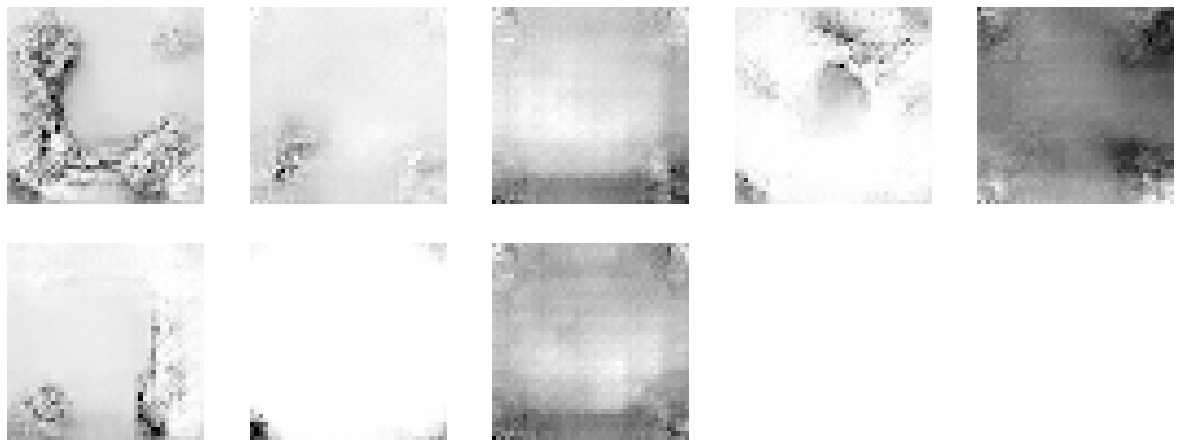

Epoch 4, Generator loss: 1.605834722518921, discriminator loss: 0.4066181182861328


In [23]:
gen_loss_list = []
disc_loss_list = []

test_noise = get_noise(PREP_BATCH_SIZE, RUN_Z_DIM, RUN_DEVICE)

# Run epoch.
for epoch in range(RUN_EPOCHS):
    
    # Set loader count and length for showing the last result of the epoch.
    loader_count = 0
    loader_length = len(loader_train)
    
    # Inside the epoch run each batch from the dataloader.
    for real, _ in tqdm(loader_train):
        # Increase counter.
        loader_count += 1
        
        # Set real image to choosen device.
        real = real.to(RUN_DEVICE)

        ## Update discriminator.
        disc_opt.zero_grad()
        fake_noise = get_noise(PREP_BATCH_SIZE, RUN_Z_DIM, RUN_DEVICE)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, to.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, to.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        
        # Update gradients.
        disc_loss.backward(retain_graph=True)
        
        # Update optimizer.
        disc_opt.step()

        #mean_iteration_critic_loss = 0
        #for _ in range(RUN_CRITICS_REPEAT):
        #    ### Update critic ###
        #    crit_opt.zero_grad()
        #    fake_noise = get_noise(len(real), z_dim, device=device)
        #    fake = gen(fake_noise)
        #    crit_fake_pred = crit(fake.detach())
        #    crit_real_pred = crit(real)

        #    epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
        #    gradient = get_gradient(crit, real, fake.detach(), epsilon)
        #    gp = gradient_penalty(gradient)
        #    crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

        #    # Keep track of the average critic loss in this batch
        #    mean_iteration_critic_loss += crit_loss.item() / crit_repeats
        #    # Update gradients
        #    crit_loss.backward(retain_graph=True)
        #    # Update optimizer
        #    crit_opt.step()
        #critic_losses += [mean_iteration_critic_loss]
        
        
        ## Update generator.
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(len(real), RUN_Z_DIM, device=RUN_DEVICE)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, to.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        ## Show the generated images.
        if loader_count == loader_length:
            gen_loss_value = gen_loss.item()
            disc_loss_value = disc_loss.item()
            
            gen_loss_list.append(gen_loss_value)
            disc_loss_list.append(disc_loss_value)

            gen.eval()
            predictions = gen(test_noise)
            print(predictions.size())
            pred_result = predictions.cpu().detach().numpy()
            print(pred_result.shape[0])
            fig = plt.figure(figsize=(21,21)) 

            for i in range(pred_result.shape[0]):
                plt.subplot(5, 5, i+1)
                
                plt.imshow(pred_result[i][0] * 127.5 + 127.5, cmap='gray')
                plt.axis('off')

            plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
            plt.show()
            gen.train()
            
            print(f"Epoch {epoch}, Generator loss: {gen_loss_value}, discriminator loss: {disc_loss_value}")

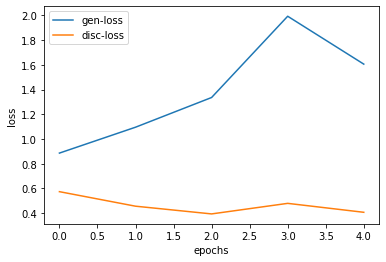

In [24]:
plt.plot(np.array(gen_loss_list), label='gen-loss')
plt.plot(np.array(disc_loss_list), label='disc-loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [26]:
import glob

anim_file = 'norb_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmp/ipykernel_112/1457807327.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_112/1457807327.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [6]:
from IPython.display import Image
Image(url='norb_dcgan.gif')  